In [5]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import acoular as ac
import matplotlib.animation as anim


In [6]:

dataName = '2025-01-28_15-18-43_492418'

resFolderName = 'out/beamforming_results_25_02_16/'+dataName

cameraPosition = 1
dotsize = 4
currentFrequencyBand = 1
currentFrame = 60

cameraAngles = np.array([[-133.33136452241695,-27.020027669675454],[164.2465834869733,64.11592446841624]]) # dim[0] = cam1/2; dim[1] = azimuth/elevation
bassoon_low_xyz = [0.97081132, 0.98296962, 0.41316809]
bassoon_high_xyz = [0.53056959, 0.3204048, 1.48546785]


# Open and read the JSON file
with open(resFolderName + '/evaluation_config.json', 'r') as file:
    config_data = json.load(file)

# Access the output folder path
out_folder = config_data['out_folder']
print(f"Output Folder: {out_folder}")

# read Data
result = np.load(resFolderName+ '/result_'+dataName + ".npy")
map = result
maxValue = np.max(map[currentFrequencyBand])
resolution = config_data['calc_grid_res_meters']
frequencyBands = config_data['frequency_bands']
frameRate = config_data['frame_rate_fps']

Output Folder: ./evaluation/out/


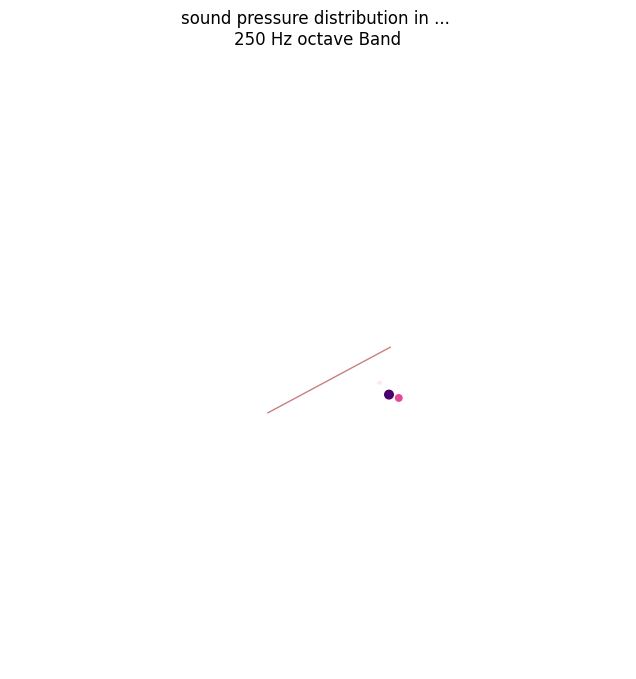

MovieWriter ffmpeg unavailable; using Pillow instead.


In [ ]:
fig = plt.figure(figsize = [10,8])
ax = fig.add_subplot(projection='3d')

# ax.view_init(elev=10, 
#              azim=270, 
#              roll=0)
ax.view_init(elev=cameraAngles[0,cameraPosition-1], 
             azim=cameraAngles[1,cameraPosition-1], 
             roll=0)
ax.set_proj_type('persp', focal_length=0.547)

x_m, y_m, z_m = np.meshgrid(np.linspace(0,map.shape[2]*resolution,map.shape[2]),
                            np.linspace(0,map.shape[3]*resolution,map.shape[3]), 
                            np.linspace(0,map.shape[4]*resolution,map.shape[4]))


# bassoon:
x_line = [bassoon_low_xyz[0], bassoon_high_xyz[0]]
y_line = [bassoon_low_xyz[1], bassoon_high_xyz[1]]
z_line = [bassoon_low_xyz[2], bassoon_high_xyz[2]]
ax.plot(x_line, y_line, z_line, linewidth=1, color='brown', alpha=0.6)

# scat = ax.scatter(x_m, y_m, z_m, c = map[1,1], s = map[1,1]*10**dotsize, alpha = 0.8, cmap = 'RdPu')
# # -map[1,1]
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')
# ax.set_xlim(0, map.shape[2]*resolution)
# ax.set_ylim(map.shape[3]*resolution, 0)
# ax.set_zlim(0,map.shape[4]*resolution)
# ax.set_title('sound pressure distribution \n in '+str(currentFrequencyBand)+' Hz octave Band')
# ax.set_aspect('equal')


scat = ax.scatter(x_m, y_m, z_m,
                   c = map[currentFrequencyBand,currentFrame],
                     s = map[currentFrequencyBand,currentFrame]*10**dotsize,
                       cmap='RdPu',
                         alpha= -map[currentFrequencyBand,currentFrame] / maxValue + 1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim(0, map.shape[2]*resolution)
ax.set_ylim(map.shape[3]*resolution, 0)
ax.set_title('sound pressure distribution in ... \n'+str(frequencyBands[currentFrequencyBand])+' Hz octave Band')
ax.set_aspect('equal')

# Remove the grey background and tick lines
ax.xaxis.pane.fill = True
ax.yaxis.pane.fill = True
ax.zaxis.pane.fill = True
ax.xaxis.pane.set_facecolor('white')
ax.yaxis.pane.set_facecolor('white')
ax.zaxis.pane.set_facecolor('white')
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_axis_off()




def update(frame):
    size = map[currentFrequencyBand, frame, :, :, :].flatten() * 10**dotsize
    scat.set_sizes(size)

    alpha= -map[currentFrequencyBand,currentFrame] / maxValue + 1
    
    # Reshape the color array to (N,) where N is the number of points
    color = map[currentFrequencyBand, frame, :, :, :].flatten()
    
    # Normalize color values to be between 0 and 1
    color = (color - np.min(color)) / (np.max(color) - np.min(color) + 1e-6)
    
    # Apply colormap
    cmap = plt.get_cmap('RdPu')
    color_rgba = cmap(color)
    
    scat.set_color(color_rgba)
    
    return scat,

ani = anim.FuncAnimation(fig=fig, func=update, frames=map.shape[1], interval=(1/25)*1000) # todo get framerate from config file
plt.show()

resFileName = 'out/video_data/' + dataName + '_camera_' + str(cameraPosition)
ani.save(filename=resFileName)
